In [2]:
import pandas as pd 
import numpy as np
from urllib.parse import urlparse
import re
from collections import Counter
from sklearn.metrics import roc_auc_score
import math
import tld
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


DATA_PATH = 'data/phishing.csv'

In [3]:
data = pd.read_csv(DATA_PATH)

data.head()

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


In [4]:
# Is it balanced?

n_legitimate = data['status'].value_counts()['legitimate']
n_phishing = data['status'].value_counts()['phishing']

print(f"Number of legitimate websites: {n_legitimate}")
print(f"Number of phishing websites: {n_phishing}")

Number of legitimate websites: 5715
Number of phishing websites: 5715


#### Feature extraction

In [5]:
def shannon_entropy(string):
    prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
    entropy = - sum([p * math.log(p) / math.log(2.0) for p in prob])
    return entropy

def relative_entropy(string, baseline_dist):
    # Calculate character distribution in string
    char_counts = Counter(string)
    string_dist = {char: count/len(string) for char, count in char_counts.items()}
    
    # Calculate relative entropy
    rel_entropy = 0
    for char in string_dist:
        if char in baseline_dist:
            rel_entropy += string_dist[char] * math.log2(string_dist[char] / baseline_dist[char])
    return rel_entropy

def count_dots(url):
    return url.count('.')

def count_hyphens(url):
    return url.count('-')

def url_length(url):
    return len(url)

def domain_length(url):
    try:
        domain = urlparse(url).netloc
        return len(domain)
    except:
        return 0

def path_length(url):
    try:
        path = urlparse(url).path
        return len(path)
    except:
        return 0

def has_https(url):
    return int(url.startswith('https'))

def count_subdomains(url):
    try:
        domain = urlparse(url).netloc
        return domain.count('.') + 1
    except:
        return 0

def digit_ratio(url):
    try:
        domain = urlparse(url).netloc
        digits = sum(c.isdigit() for c in domain)
        return digits / len(domain) if len(domain) > 0 else 0
    except:
        return 0

def is_known_tld(url):
    try:
        res = tld.get_tld(url, as_object=True, fail_silently=True)
        return 1 if res else 0
    except:
        return 0

def count_suspicious_words(url):
    suspicious = ['login', 'account', 'banking', 'secure', 'update', 'verify',
                  'signin', 'ebayisapi', 'webscr', 'security', 'password',
                  'credentials', 'information', 'alert', 'urgent', 'notification',
                  'confirm', 'billing', 'service', 'paypal', 'verify', 'claim',
                  'reward', 'free', 'prize', 'limited', 'offer', 'restricted',
                  'bankofamerica', 'wellsfargo']
    return sum(word in url.lower() for word in suspicious)

def has_ip_address(url):
    ip_pattern = r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}'
    return int(bool(re.search(ip_pattern, url)))

def count_vowels(url):
    return sum(c in 'aeiouAEIOU' for c in url)

def count_special_chars(url):
    special_chars = '!@#$%^&*()_+={}[]|\\:;"\'<>?,/~`'
    return sum(c in special_chars for c in url)

In [6]:
feature_funcs = {
    'shannon_entropy': shannon_entropy,
    'dots_count': count_dots,
    'hyphens_count': count_hyphens,
    'url_length': url_length,
    'domain_length': domain_length,
    'path_length': path_length,
    'has_https': has_https,
    'subdomain_count': count_subdomains,
    'digit_ratio': digit_ratio,
    'known_tld': is_known_tld,
    'suspicious_words': count_suspicious_words,
    'has_ip': has_ip_address,
    'vowels_count': count_vowels,
    'special_chars': count_special_chars
}

# Apply all feature functions
for feature, func in feature_funcs.items():
    data[feature] = data['url'].apply(func)

# Add relative entropy separately due to baseline_dist parameter
# Character frequency distribution for domain names based on Alexa Top 1 Million domains.
# Source: Red Canary Blog - https://redcanary.com/blog/threat-detection/threat-hunting-entropy/
# (Accessed on January 30, 2024)
baseline_dist = {
    '-': 0.013342298553905901,
    '_': 9.04562613824129e-06,
    '0': 0.0024875471880163543,
    '1': 0.004884638114650296,
    '2': 0.004373560237839663,
    '3': 0.0021136613076357144,
    '4': 0.001625197496170685,
    '5': 0.0013070929769758662,
    '6': 0.0014880054997406921,
    '7': 0.001471421851820583,
    '8': 0.0012663876593537805,
    '9': 0.0010327089841158806,
    'a': 0.07333590631143488,
    'b': 0.04293204925644953,
    'c': 0.027385633133525503,
    'd': 0.02769469202658208,
    'e': 0.07086192756262588,
    'f': 0.01249653250998034,
    'g': 0.038516276096631406,
    'h': 0.024017645001386995,
    'i': 0.060447396668797414,
    'j': 0.007082725266242929,
    'k': 0.01659570875496002,
    'l': 0.05815885325582237,
    'm': 0.033884915513851865,
    'n': 0.04753175014774523,
    'o': 0.09413783122067709,
    'p': 0.042555148167356144,
    'q': 0.0017231917793349655,
    'r': 0.06460084667060655,
    's': 0.07214640647425614,
    't': 0.06447722311338391,
    'u': 0.034792493336388744,
    'v': 0.011637198026847418,
    'w': 0.013318176884203925,
    'x': 0.003170491961453572,
    'y': 0.016381628936354975,
    'z': 0.004715786426736459
}
data['relative_entropy'] = data['url'].apply(lambda x: relative_entropy(x, baseline_dist))

# Convert status to binary and drop URL column
data['status'] = (data['status'] == 'phishing').astype(int)
data = data.drop('url', axis=1)

data.head()

,status,shannon_entropy,dots_count,hyphens_count,url_length,domain_length,path_length,has_https,subdomain_count,digit_ratio,known_tld,suspicious_words,has_ip,vowels_count,special_chars,relative_entropy
0,0,3.787043,3,0,37,19,11,0,3,0.0,1,0,0,8,4,0.594928
1,1,4.419864,1,0,77,23,47,0,2,0.0,1,0,0,24,6,0.886396
2,1,4.753412,4,1,126,50,20,1,5,0.0,1,2,0,30,14,0.703721
3,0,3.461320,2,0,18,11,0,0,3,0.0,1,0,0,3,3,0.611203
4,0,4.097662,2,2,55,15,33,0,3,0.0,1,0,0,12,6,0.360853


### Analysis

Index(['status', 'shannon_entropy', 'dots_count', 'hyphens_count',
       'url_length', 'domain_length', 'path_length', 'has_https',
       'subdomain_count', 'digit_ratio', 'known_tld', 'suspicious_words',
       'has_ip', 'vowels_count', 'special_chars', 'relative_entropy'],
      dtype='object')


/var/folders/g7/1ym58dj93f13x5_nxk6zr72m0000gn/T/ipykernel_20534/2386216017.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data[data['status']==0][feature], label='Legitimate', fill=True, alpha=0.5)


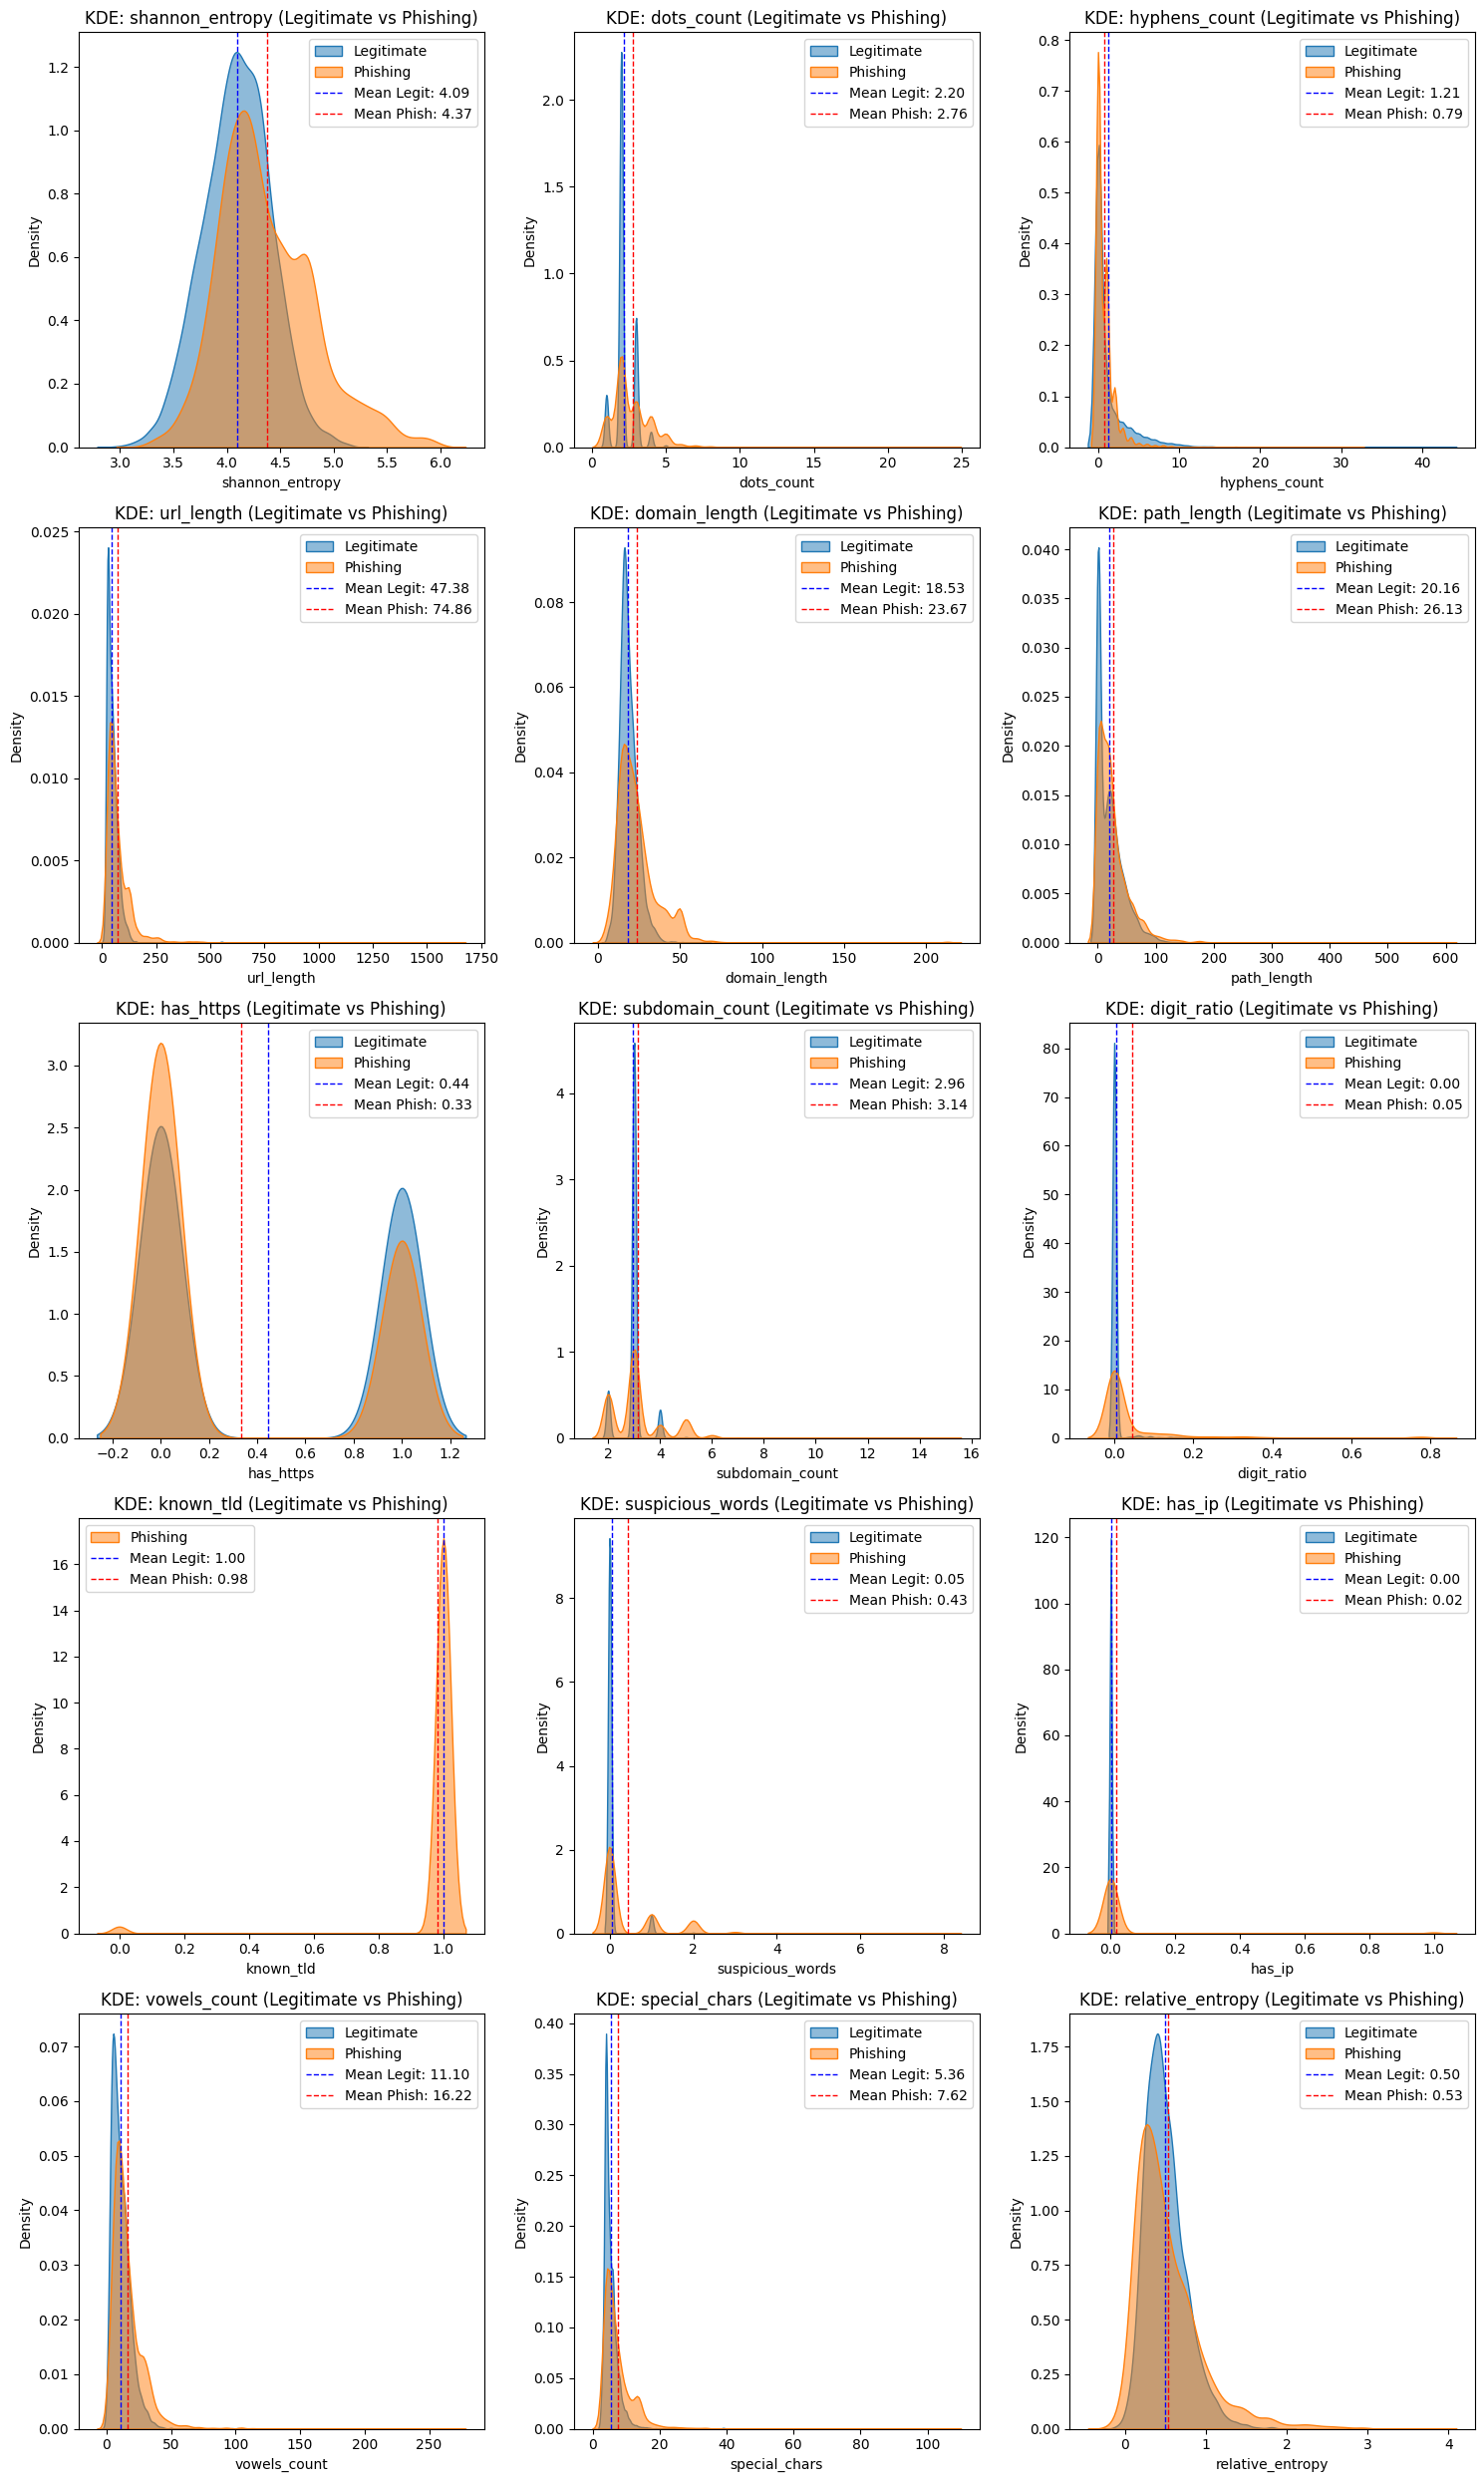

/var/folders/g7/1ym58dj93f13x5_nxk6zr72m0000gn/T/ipykernel_20534/2386216017.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y=feature, data=data, palette="viridis")
/var/folders/g7/1ym58dj93f13x5_nxk6zr72m0000gn/T/ipykernel_20534/2386216017.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y=feature, data=data, palette="viridis")
/var/folders/g7/1ym58dj93f13x5_nxk6zr72m0000gn/T/ipykernel_20534/2386216017.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y=feature, data=data, palette="viridis")
/

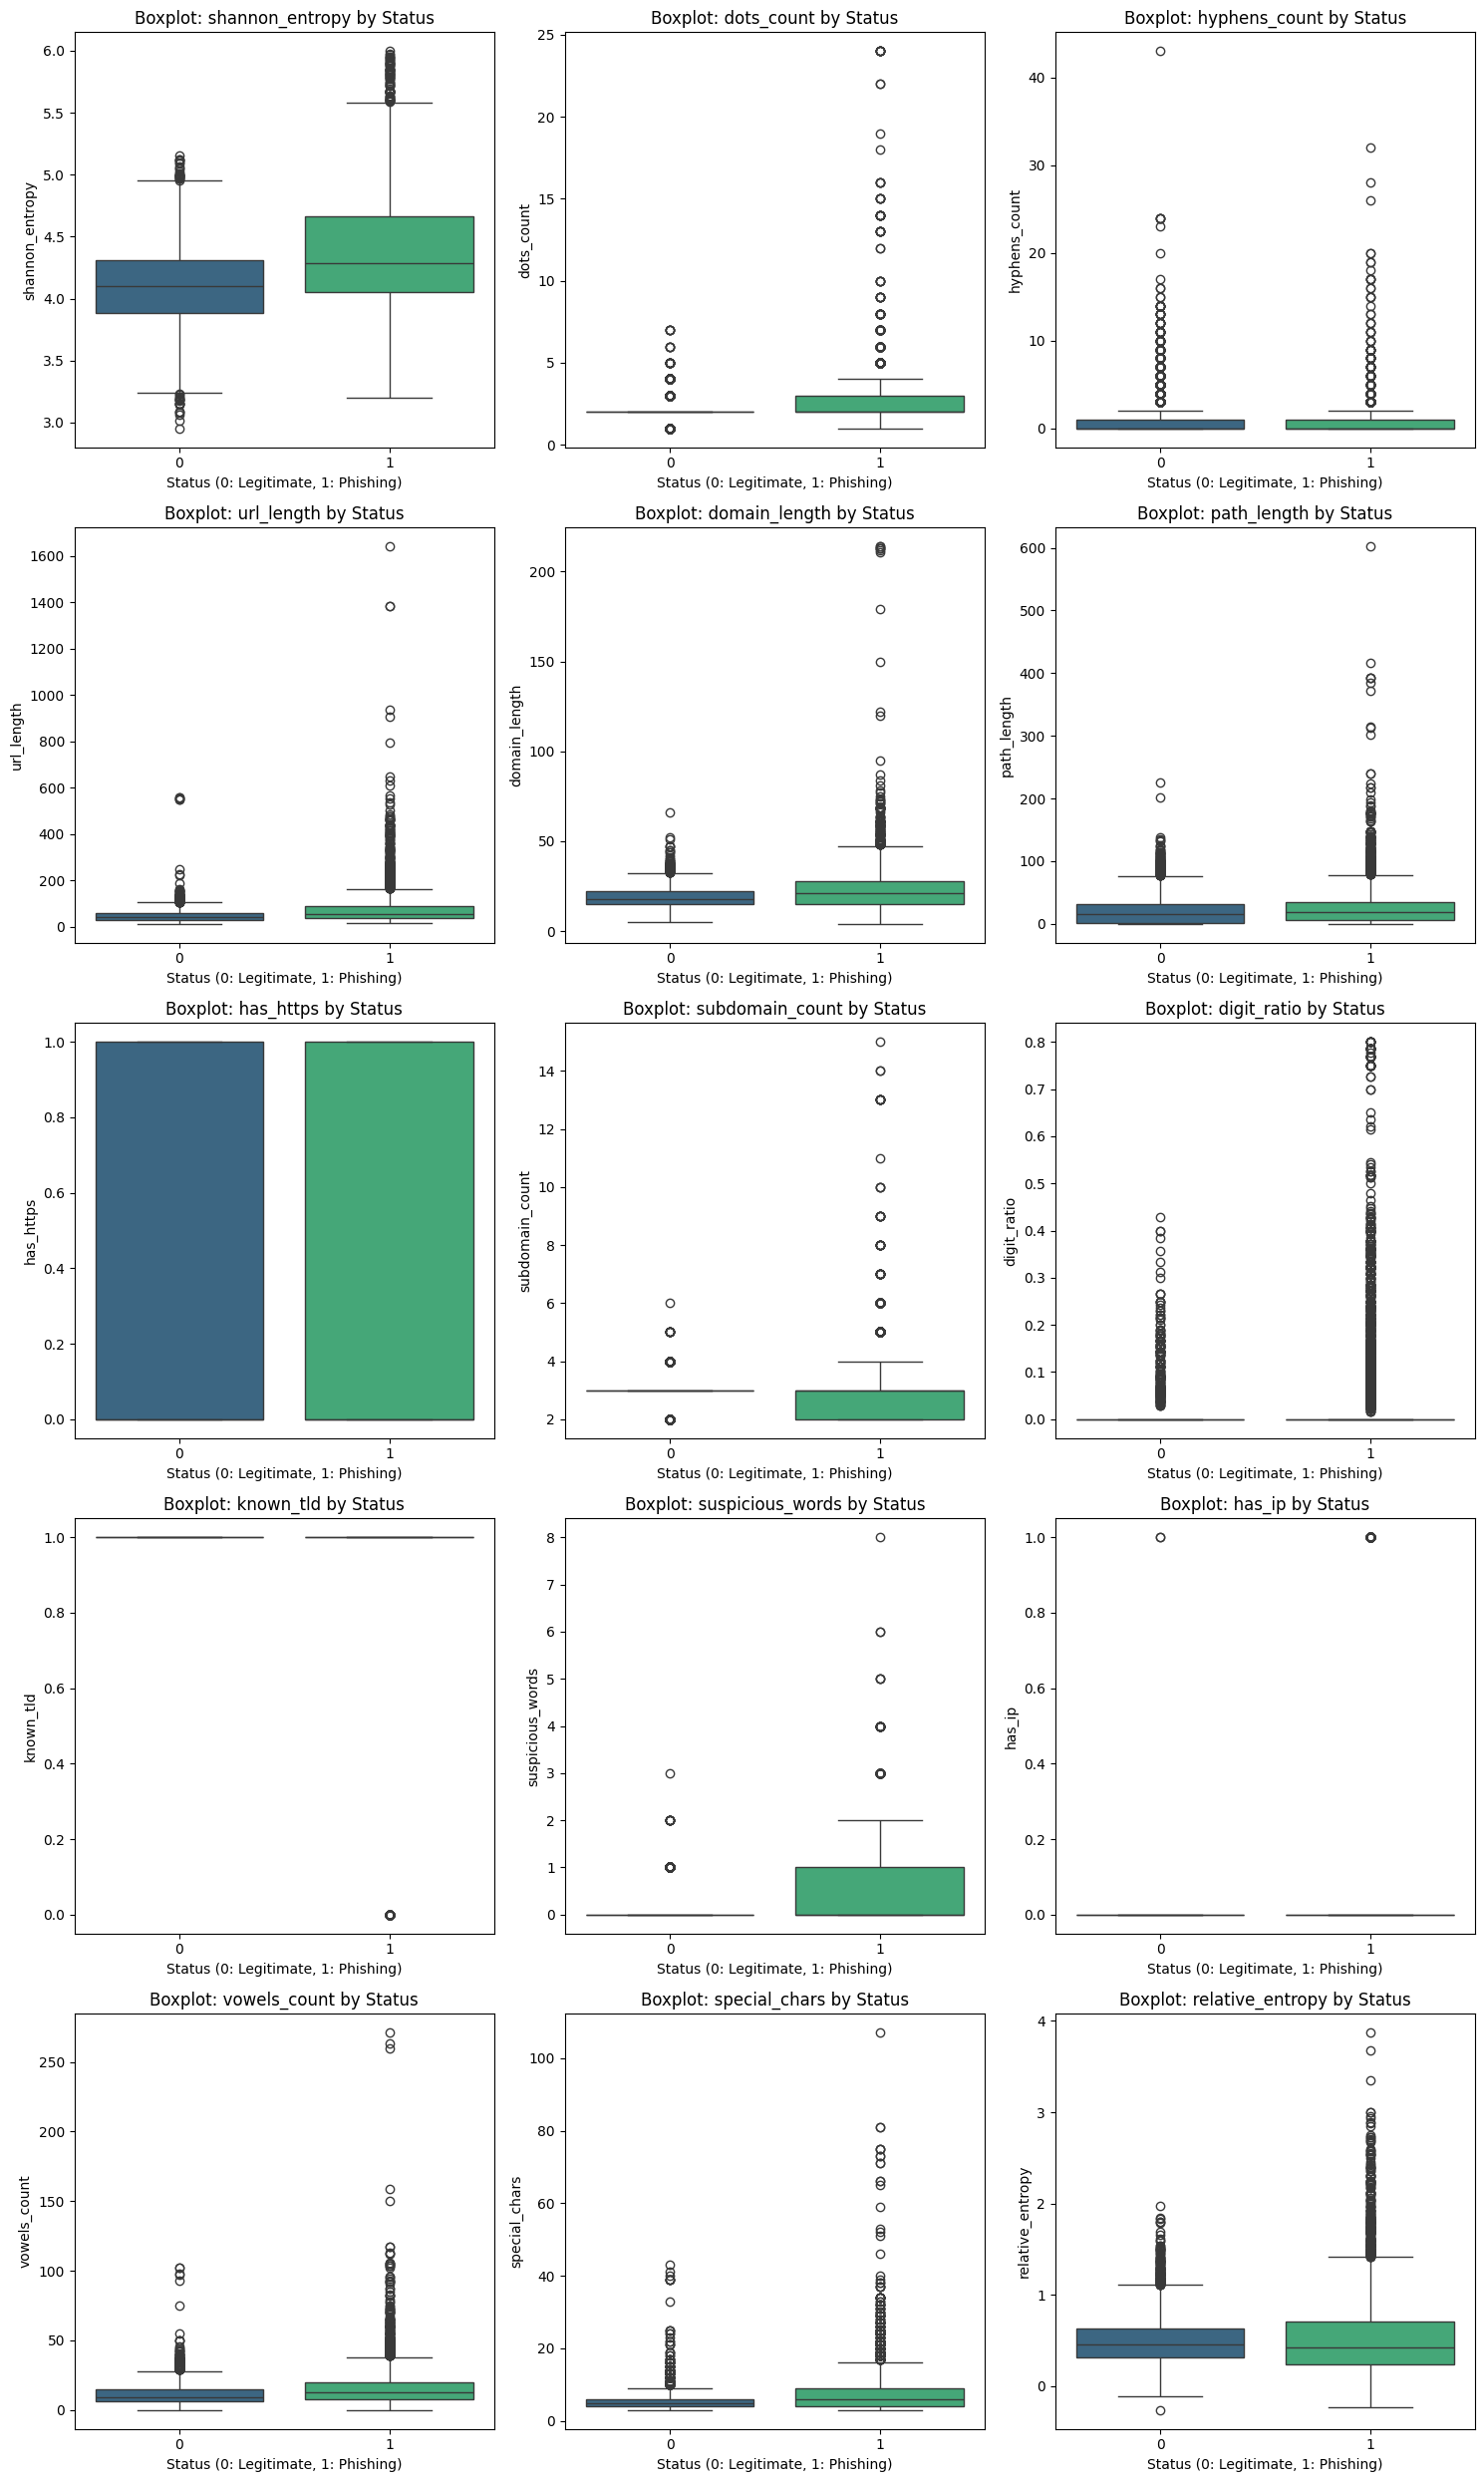

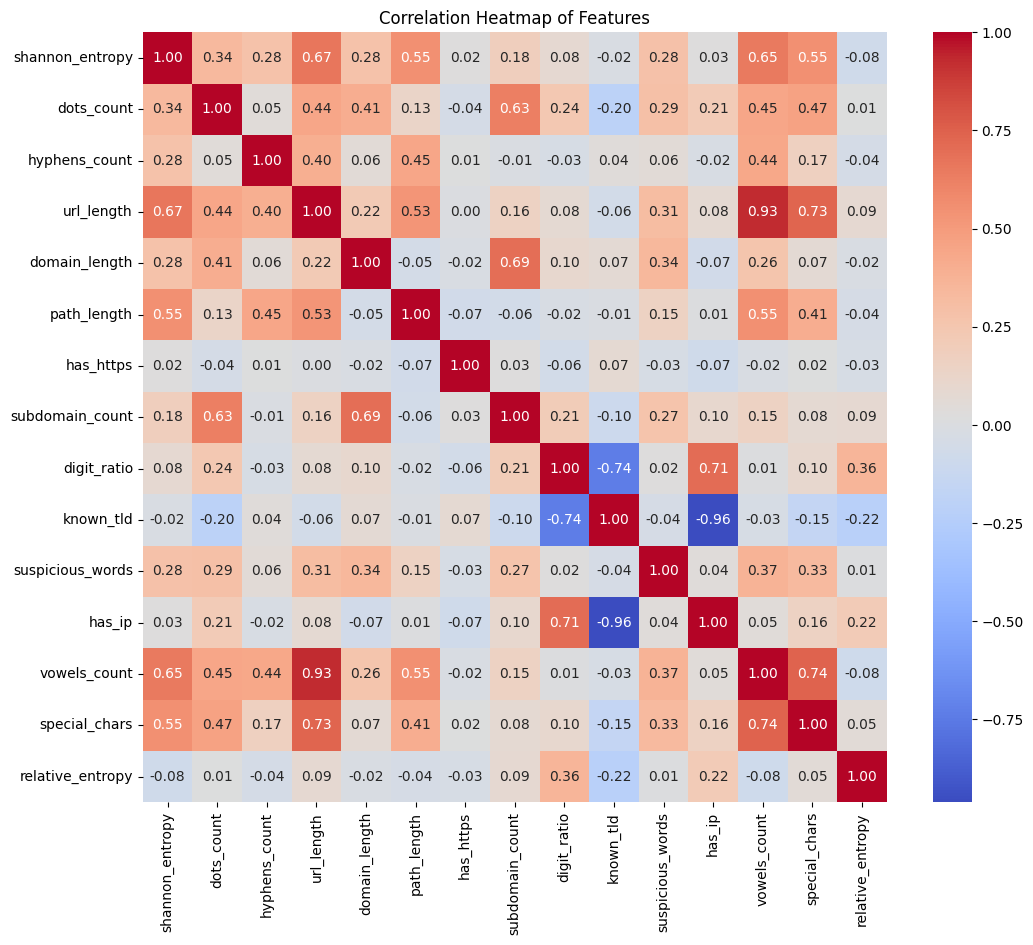


Estadísticas descriptivas para URLs legítimas:
       status  shannon_entropy   dots_count  hyphens_count   url_length  \
count  5715.0      5715.000000  5715.000000    5715.000000  5715.000000   
mean      0.0         4.094256     2.197200       1.206474    47.381452   
std       0.0         0.317618     0.655975       2.423501    27.862702   
min       0.0         2.952820     1.000000       0.000000    12.000000   
25%       0.0         3.880180     2.000000       0.000000    29.000000   
50%       0.0         4.100922     2.000000       0.000000    41.000000   
75%       0.0         4.309101     2.000000       1.000000    59.000000   
max       0.0         5.155280     7.000000      43.000000   557.000000   

       domain_length  path_length    has_https  subdomain_count  digit_ratio  \
count    5715.000000  5715.000000  5715.000000      5715.000000  5715.000000   
mean       18.529484    20.160980     0.444969         2.964129     0.004377   
std         5.426438    22.833236   

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# List all the features
print(data.columns)

features_to_plot = data.columns.drop('status')
n_features = len(features_to_plot)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols


# 1. KDE Plots (with mean lines)
plt.figure(figsize=(15, 5*n_rows))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.kdeplot(data=data[data['status']==0][feature], label='Legitimate', fill=True, alpha=0.5)
    sns.kdeplot(data=data[data['status']==1][feature], label='Phishing', fill=True, alpha=0.5)

    # Add vertical lines for means
    mean_legit = data[data['status']==0][feature].mean()
    mean_phish = data[data['status']==1][feature].mean()
    plt.axvline(mean_legit, color='blue', linestyle='--', linewidth=1, label=f'Mean Legit: {mean_legit:.2f}')
    plt.axvline(mean_phish, color='red', linestyle='--', linewidth=1, label=f'Mean Phish: {mean_phish:.2f}')

    plt.title(f'KDE: {feature} (Legitimate vs Phishing)')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()


# 2. Box Plots
plt.figure(figsize=(15, 5*n_rows))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x='status', y=feature, data=data, palette="viridis")
    plt.title(f'Boxplot: {feature} by Status')
    plt.xlabel('Status (0: Legitimate, 1: Phishing)')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

#  3. Correlaion Plot
corr = data[features_to_plot].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

# Descriptive statistics (KEEP THIS FOR YOUR ANALYSIS, BUT DON'T INCLUDE IN FULL IN REPORT)
print("\nEstadísticas descriptivas para URLs legítimas:")
print(data[data['status']==0].describe())
print("\nEstadísticas descriptivas para URLs de phishing:")
print(data[data['status']==1].describe())

In [8]:
# 1. Check for low variance features
variance = data.var()
low_variance_features = variance[variance < 0.01].sort_values()
print("Features with very low variance (< 0.01, consider removing):")
for feat, var in low_variance_features.items():
    print(f"{feat}: {var:.6f}")
print("\n")

# 2. Check for highly correlated features
correlation_matrix = data.corr()
# Get upper triangle of correlations
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_corr_pairs = [(i, j, correlation_matrix.loc[i,j]) 
                   for i in upper.index 
                   for j in upper.columns 
                   if abs(upper.loc[i,j]) > 0.8]

print("Highly correlated feature pairs (|corr| > 0.8, consider removing one):")
for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
    print(f"{feat1} - {feat2}: {corr:.3f}")
print("\n")

# 3. Analyze feature importance using multiple metrics
feature_analysis = pd.DataFrame(index=data.columns.drop('status'))

# Add variance
feature_analysis['variance'] = variance

# Add correlation with target
feature_analysis['target_correlation'] = correlation_matrix['status'].abs()

# Add ROC AUC scores
for feature in feature_analysis.index:
    auc = roc_auc_score(data['status'], data[feature])
    feature_analysis.loc[feature, 'roc_auc'] = max(auc, 1-auc)

# Sort by ROC AUC (most reliable metric for binary classification)
feature_analysis = feature_analysis.sort_values('roc_auc', ascending=False)

print("Feature importance analysis (sorted by ROC AUC):")
print(feature_analysis.round(4))

# Recommendation summary
print("\nRecommended features to keep (ROC AUC > 0.6 and variance > 0.01):")
good_features = feature_analysis[
    (feature_analysis['roc_auc'] > 0.6) & 
    (feature_analysis['variance'] > 0.01)
].index
for feature in good_features:
    print(f"- {feature}")

Features with very low variance (< 0.01, consider removing):
known_tld: 0.008415
digit_ratio: 0.008777
has_ip: 0.009103


Highly correlated feature pairs (|corr| > 0.8, consider removing one):
known_tld - has_ip: -0.961
url_length - vowels_count: 0.925


Feature importance analysis (sorted by ROC AUC):
                   variance  target_correlation  roc_auc
shannon_entropy      0.1708              0.3366   0.6758
url_length        3057.2573              0.2485   0.6642
special_chars       20.8354              0.2471   0.6516
vowels_count       129.8041              0.2247   0.6341
suspicious_words     0.3642              0.3146   0.6203
domain_length      116.1724              0.2385   0.6074
digit_ratio          0.0088              0.2239   0.5966
dots_count           1.8760              0.2070   0.5929
path_length        769.4008              0.1076   0.5670
has_https            0.2377              0.1147   0.5559
relative_entropy     0.1236              0.0420   0.5309
has_ip      

### Preprocessing 


In [10]:
selected_columns = [
    'status',
    'shannon_entropy',
    'url_length',
    'special_chars',
    'suspicious_words',
    'domain_length',
    'vowels_count',
    'dots_count'
]

# Create a new DataFrame with selected columns
data_selected = data[selected_columns]

data_selected = data[selected_columns]

# Separate the features and the target
X = data_selected.drop('status', axis=1)
y = data_selected['status']

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Combine the target with the standardized features
data_processed = pd.concat([y, X_scaled_df], axis=1)

# Split the processed data into train (55%), validation (15%), and test (30%)
train_data, temp_data = train_test_split(
    data_processed, test_size=0.45, random_state=42, stratify=data_processed["status"]
)

# From the temporary set, split into validation and test sets.
# Since temp_data represents 45% of the data, splitting with test_size=0.6667 gives:
# validation: 15% of total (33.33% of temp_data), test: 30% of total (66.67% of temp_data)
validation_data, test_data = train_test_split(
    temp_data, test_size=0.6667, random_state=42, stratify=temp_data["status"]
)

# Ensure the "data" directory exists to save the CSV files
os.makedirs('data', exist_ok=True)

# Save the resulting datasets as CSV files with distinctive English names
train_data.to_csv("data/processed_train_data.csv", index=False)
validation_data.to_csv("data/processed_validation_data.csv", index=False)
test_data.to_csv("data/processed_test_data.csv", index=False)

print("Preprocessing complete. CSV files saved in the 'data' directory.")


   status  shannon_entropy  url_length  special_chars  suspicious_words  \
0       0         3.787043          37              4                 0   
1       1         4.419864          77              6                 0   
2       1         4.753412         126             14                 2   
3       0         3.461320          18              3                 0   
4       0         4.097662          55              6                 0   

   domain_length  vowels_count  dots_count  
0             19             8           3  
1             23            24           1  
2             50            30           4  
3             11             3           2  
4             15            12           2  
